In [1]:
from math import log, exp, sqrt, fabs, sin, cos, atan2, tan
import sys
import numpy as np
from numpy import eye, zeros, dot, isscalar, outer
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.linalg import norm
import scipy.stats as stats
from ukf import *
from process_measurement import ctrv, lidar



In [2]:
def plot_trajectory_xy(x_gt, y_gt, x_e, y_e, x_mea, y_mea, x_lim, y_lim, fig_size = [20, 4], idx = None, save_fig = False):
    plt.figure(figsize = fig_size)
    plt.cla()
    plt.plot(x_gt, y_gt, 'k-',linewidth = 3) # ground truth
    plt.plot(x_e, y_e, 'r', linewidth = 2)  # estimate
    plt.plot(x_mea, y_mea, 'g.', alpha = 0.3) # measurement
    plt.legend(['Ground Truth', 'Estimation', 'Measurement'])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.axis('equal') # very important for visualization purpose
    plt.gca().invert_yaxis()
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    if save_fig:
        plt.savefig('frame%03d.png' %idx)
    plt.pause(0.002)

In [3]:
def plot_trajectory_xy_t(x_gt, y_gt, x_e, y_e, x_mea, y_mea, x_lim, y_lim, fig_size = [10, 8]):
    plt.figure(figsize = fig_size)
    plt.subplot(2, 1, 1)
    plt.plot(x_gt, 'k-',linewidth = 3) # ground truth
    plt.plot(x_e,  'r', linewidth = 2)  # estimate
    plt.plot(x_mea, 'g.', alpha = 0.3) # measurement
    plt.legend(['Ground Truth', 'Estimation', 'Measurement'])
    plt.xlabel("Time steps")
    plt.ylabel("X")
    plt.grid()
    plt.ylim(x_lim)
    plt.subplot(2, 1, 2)
    plt.plot(y_gt, 'k-',linewidth = 3) # ground truth
    plt.plot(y_e,  'r', linewidth = 2)  # estimate
    plt.plot(y_mea, 'g.', alpha = 0.3) # measurement
    plt.legend(['Ground Truth', 'Estimation', 'Measurement'])
    plt.xlabel("Time steps")
    plt.ylabel("Y")
    plt.grid()
   
    plt.ylim(y_lim)
    plt.show()

In [12]:
def plot_velocity_t(vx_gt, vy_gt, vx_e, vy_e, x_lim, y_lim, fig_size = [10, 8]):
    plt.figure(figsize = fig_size)
    plt.subplot(2, 1, 1)
    plt.plot(vx_gt, 'k-',linewidth = 3) # ground truth
    plt.plot(vx_e,  'r', linewidth = 2)  # estimate
    plt.legend(['Ground Truth', 'Estimation', 'Measurement'])
    plt.xlabel("Time steps")
    plt.ylabel("Vx")
    plt.grid()
    plt.ylim(x_lim)
    plt.subplot(2, 1, 2)
    plt.plot(vy_gt, 'k-',linewidth = 3) # ground truth
    plt.plot(vy_e,  'r', linewidth = 2)  # estimate
    plt.legend(['Ground Truth', 'Estimation', 'Measurement'])
    plt.xlabel("Time steps")
    plt.ylabel("Vy")
    plt.grid()
   
    plt.ylim(y_lim)
    plt.show()

In [4]:
gt_np = np.load('gt_car3.npz')['X']
lidar_np = np.load('lidar_car3.npz')['X']
print(gt_np[0])
print(lidar_np[0])

[  0.       2.     -11.9667   0.       1.       0.    ]
[  0.          2.        -11.7982     -0.0824619]


In [5]:
dt = (gt_np[1][0] - gt_np[0][0])/1e6
print('delta_t: ', dt)

delta_t:  0.033333


In [32]:
ukf = UKF(dim_x = 5, dim_z = 2, fx = ctrv, hx = lidar,
              dt = dt, alpha =.00001, beta = 2, kappa = 0, sigma_mode = 1,
              augmentation = True, dim_xa = 7, xa = np.array([0, 0]),
              x_resid = True, x_resid_indices = [3], z_resid = True, z_resid_indices = [1])
x0 = np.array([-10.5, 0, 0.8, 0, 0])
P0 = np.diag([2, 2, 5, 0.0255, 0.0255])
ukf.x = x0
ukf.P = P0
std_a = 100
std_yawdd = 0.8
estimate =[]
Qa = np.diag([std_a * std_a, std_yawdd * std_yawdd])
ukf.Qa = Qa
ukf.Q = np.zeros([5,5])
ukf.R = np.diag([0.15**2, 0.15**2])
animation = False
for i in range(gt_np.shape[0]):
    ukf.prediction() 
    z0 = np.array(lidar_np[i][2:])
    ukf.update(z0)
    estimate.append([ukf.x_post[0], ukf.x_post[1],ukf.x_post[2]*cos(ukf.x_post[3]), ukf.x_post[2]*sin(ukf.x_post[3])])
    
    if animation == True:
        if i % 10 == 0:
            x_gt = gt_np[:i+1, 2]
            y_gt = gt_np[:i+1, 3]
            estimate_np = np.array(estimate)
            x_e = estimate_np[:,0]
            y_e = estimate_np[:,1]
            x_ld = lidar_np[:i+1,2]
            y_ld = lidar_np[:i+1,3]
            plot_trajectory_xy(x_gt, y_gt, x_e, y_e, x_ld, y_ld, [-15, 55], [-2, 6], idx = i)


estimate_np = np.array(estimate)

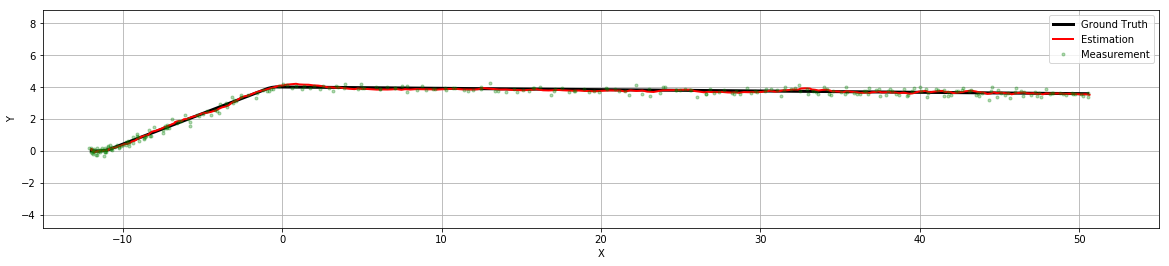

In [33]:
x_gt = gt_np[:, 2]
y_gt = gt_np[:, 3]
x_e = estimate_np[:,0]
y_e = estimate_np[:,1]
x_ld = lidar_np[:,2]
y_ld = lidar_np[:,3]
plot_trajectory_xy(x_gt, y_gt, x_e, y_e, x_ld, y_ld, x_lim = [-15, 55], y_lim =[-2, 6])
       

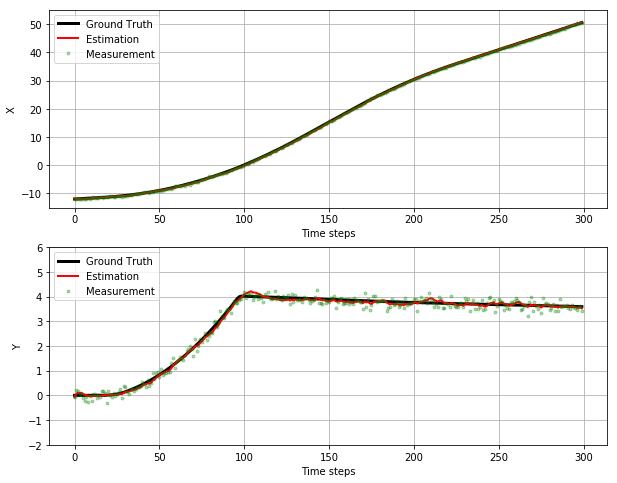

In [34]:
plot_trajectory_xy_t(x_gt, y_gt, x_e, y_e, x_ld, y_ld, x_lim = [-15, 55], y_lim = [-2, 6])

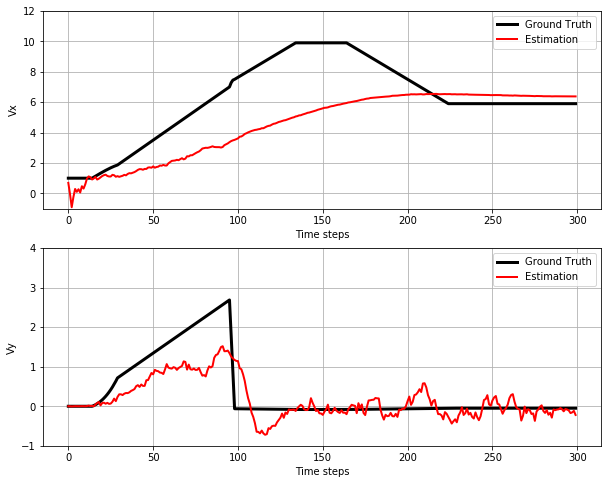

In [35]:
vx_gt = gt_np[:, 4]
vy_gt = gt_np[:, 5]
vx_e = estimate_np[:,2]
vy_e = estimate_np[:,3]
plot_velocity_t(vx_gt, vy_gt, vx_e, vy_e, [-1, 12], [-1, 4], fig_size = [10, 8])